In [1]:
import numpy as np

import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import astropy.wcs as wcs

from sklearn.mixture import GaussianMixture

## import functions
import GMM_plot_library as pGMM
import GMM_functions as fGMM
import velocity_axis_datacube as vax

#### Notebook to study the best fitting GMM model in more detail

In [2]:
#### User input ####

## input for the data file
path_file = 'data/'
name_file = 'RCW79_CII_PCA_20_8_0p5_clean.fits'
unit_integrated_intensity = '$\int$T$_{mb}$dv (K km s$^{-1}$)'

## plotting options 
dpi_val = 300
path_plots = 'plots/'

## input for the Gaussian Mixture Models
n_comps = 7

## input for the GMM
seed_val = 312
threshold = 0.001
gmm_iter = 1000

## information for the observational information
noise_rms_obs = 0.6 ## K
min_velocity = -70. ## km/s
max_velocity = -25. ## km/s
unit_intensity = "T$_{mb}$ (K)"
unit_z_axis = "v (km s$^{-1}$)"

## ratio cut
ratio_cut = 10

In [3]:
## Read the data and header information
hdu = pyfits.open(path_file + name_file)
hdu.info()
data = hdu[0].data
header = hdu[0].header

## store the spectral information (in km/s)
dv = 0.001*header['CDELT3']
crval = 0.001*header['CRVAL3']
crpix = header['CRPIX3']

## store the WCS information
header_c = header.copy()
header_c['NAXIS'] = 2
del header_c['NAXIS3']
del header_c['CTYPE3']
del header_c['CRVAL3']
del header_c['CDELT3']
del header_c['CRPIX3']
del header_c['CROTA3']

w = wcs.WCS(header_c)

Filename: data/RCW79_CII_PCA_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   


In [4]:
## reduce the data size along the z-axis to the region associated with emission
data_reduced = vax.reduce_z_axis_size(data, min_velocity, max_velocity, crval, dv, crpix)

## prepare the data before the GMM fit
index_array, data_input = fGMM.prepare_data(data_reduced)

The minimal pixel along the z-axis is: 40
The maximal pixel along the z-axis is: 130
Dimensions of resampled data: (90, 35344)


/Users/larsbonne/Documents/code/Astro/GMM/GMM_functions.py:31: RuntimeWarning: All-NaN slice encountered
  max_vals = np.nanmax(data_resample, axis=0)


In [5]:
## fit the GMM
best_model = GaussianMixture(n_components = n_comps, 
                                     init_params = 'kmeans', 
                                     covariance_type = 'full', 
                                     random_state = seed_val, 
                                     tol = threshold, 
                                     max_iter = gmm_iter).fit(data_input)

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


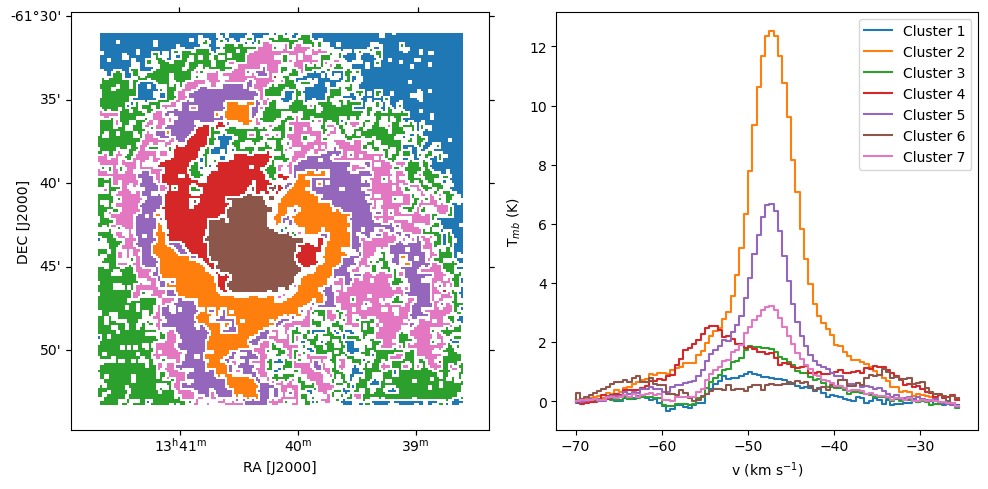

In [6]:
## Obtain the indices for the different clusters
cluster_inds = best_model.predict(data_input)

## Map the spatial distribution of the different clusters
cluster_map = fGMM.map_spatial_cluster_distribution(cluster_inds, index_array, data.shape[2], data.shape[1])

## Create the velocity and resampled velocity array necessary for plotting
vel_arr = vax.create_velocity_array(min_velocity, max_velocity, dv)

## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w)

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


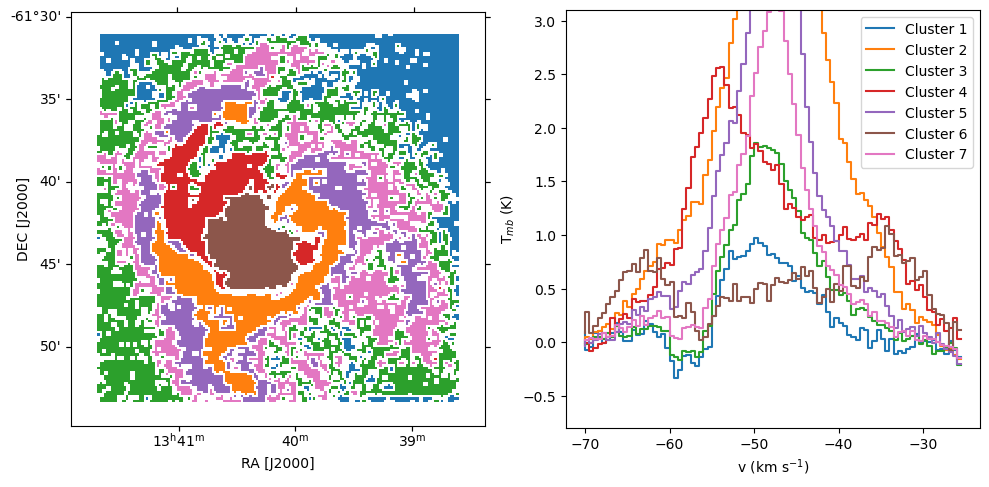

In [7]:
## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w, valrange_ax2 = [-0.8, 3.1])

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


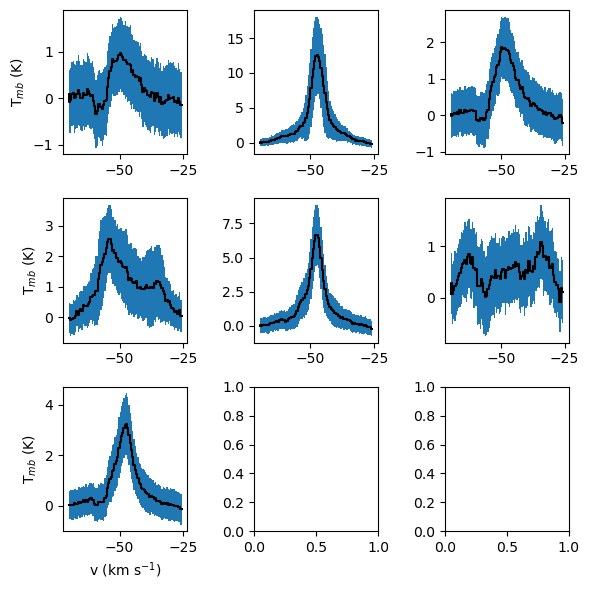

In [8]:
## Plot the spectra associated with each cluster and their standard deviation
pGMM.plot_cluster_spectra(data_reduced, cluster_map, vel_arr)

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


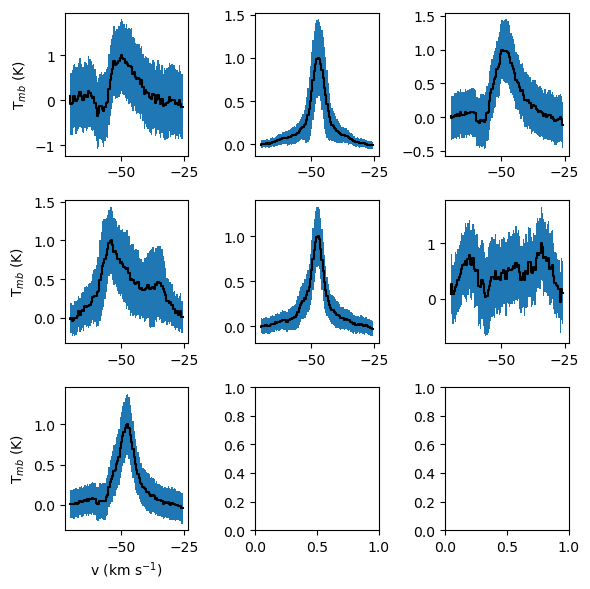

In [9]:
## Plot the normalized spectra associated with each cluster and their standard deviation
pGMM.plot_cluster_spectra(data_reduced, cluster_map, vel_arr, normalize = True)

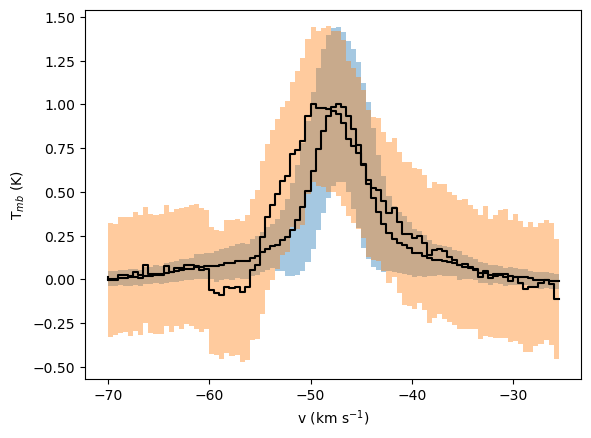

In [10]:
## Compare two spectra and their standard deviation
pGMM.compare_cluster_spectra(data_reduced, cluster_map, vel_arr)

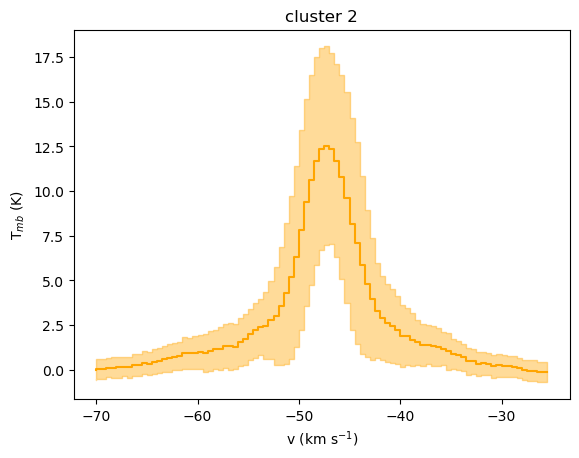

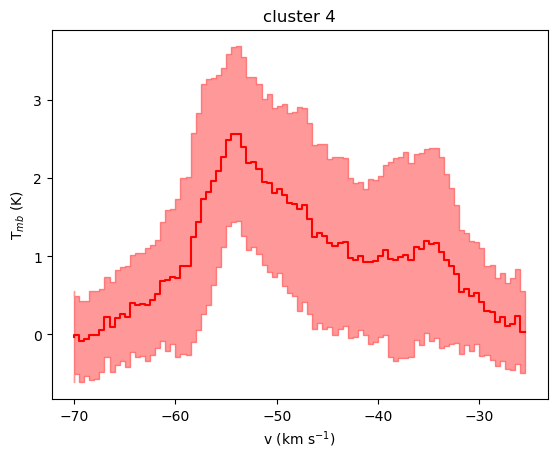

In [11]:
## Inspect the average spectrum and standard deviation of given clusters
pGMM.cluster_spectrum_std(data_reduced, cluster_map, vel_arr, cl = 1, normalize = False, col = 'orange', plot_path = 'plots/av_spec_cluster2_col.pdf')
pGMM.cluster_spectrum_std(data_reduced, cluster_map, vel_arr, cl = 3, normalize = False, col = 'red', plot_path = 'plots/av_spec_cluster4_col.pdf')

In [12]:
## explore the probability that each position belongs to a cluster
clust_probs = best_model.predict_proba(data_input)

max_probs = np.nanmax(clust_probs, axis = 1)
print(np.nanmin(max_probs))

0.4823053604472172


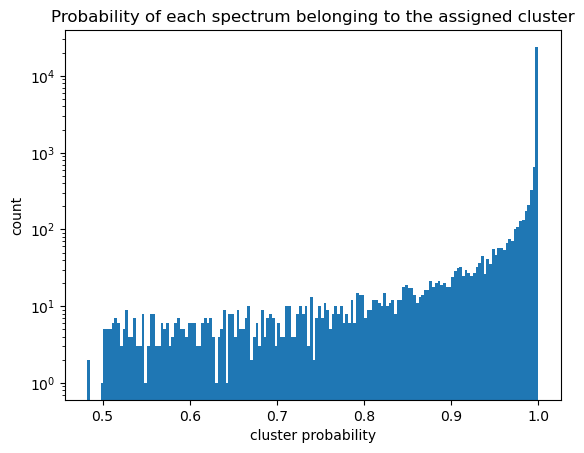

In [13]:
## plot the probability that a spectrum is part of its assigned cluster
plt.hist(max_probs, bins = int(np.sqrt(max_probs.shape[0]) + 0.5))#, density = True)
plt.yscale('log')

plt.title('Probability of each spectrum belonging to the assigned cluster')

plt.xlabel('cluster probability')
plt.ylabel('count')

plt.show()

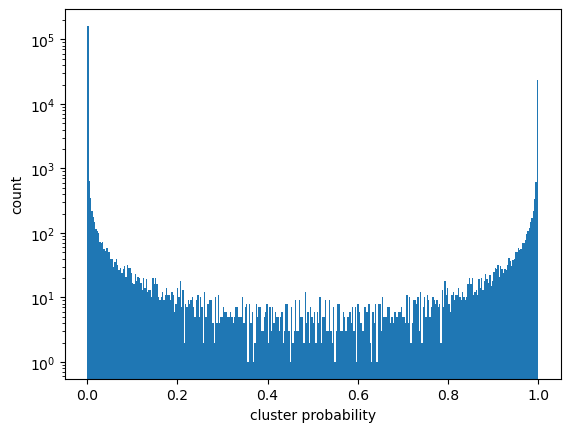

In [14]:
## plot the probability that a spectrum is part of each possible cluster
clust_probs_fl = clust_probs.flatten()
plt.hist(clust_probs_fl, bins = 2*int(np.sqrt(max_probs.shape[0]) + 0.5))#, density = True)
plt.yscale('log')

plt.xlabel('cluster probability')
plt.ylabel('count')

plt.show()

In [15]:
## quickly verify that all the probabilities sum up to 1 for each pixel
print(np.nansum(clust_probs, axis = 1))

[1. 1. 1. ... 1. 1. 1.]


In [16]:
## print the information on the best model
print(best_model.get_params)

<bound method BaseEstimator.get_params of GaussianMixture(max_iter=1000, n_components=7, random_state=312)>


In [17]:
## Determine the second largest probability that a given pixel belongs to one of the clusters

## First remove all the maximal probabilities (replace with nan)
for idx1 in range(0, max_probs.shape[0]):
    max_val = max_probs[idx1]
    for idx2  in range(0, clust_probs.shape[1]):
        if(clust_probs[idx1][idx2] == max_val):
            clust_probs[idx1][idx2] = np.nan

## Then recalculate the maximum value
max_sec_probs = np.nanmax(clust_probs, axis = 1)


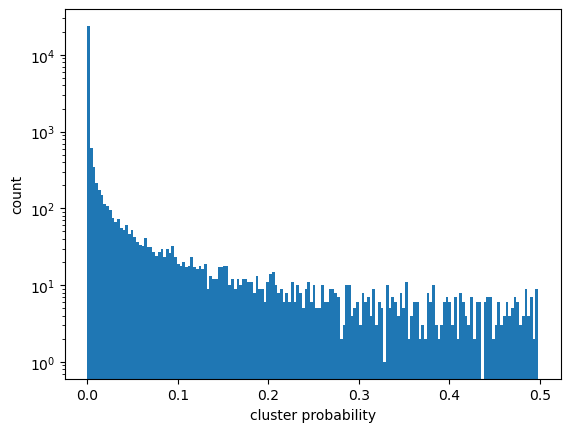

In [18]:
## plot the probabilities to verify
plt.hist(max_sec_probs, bins = int(np.sqrt(max_sec_probs.shape[0]) + 0.5))#, density = True)
plt.yscale('log')

plt.xlabel('cluster probability')
plt.ylabel('count')

plt.show()

In [19]:
## Calculate the probability ratio of the most likely cluster over the second most likely cluster
prob_ratio = max_probs / max_sec_probs

print(np.nanmin(prob_ratio))
print(np.nanmax(prob_ratio))
print(np.nanmedian(prob_ratio))

1.0048621232558201
6.681651418126257e+113
8076495.336379062


In [20]:
## set all ratios higher than the ratio cut to nan
prob_ratio[prob_ratio > ratio_cut] = np.nan

## Map the spatial distribution of the pixels with low certainty on the assigned cluster
uncertain_map = fGMM.map_uncertain_distribution(prob_ratio, index_array, data.shape[2], data.shape[1])
print(uncertain_map.shape)

(188, 188)


The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


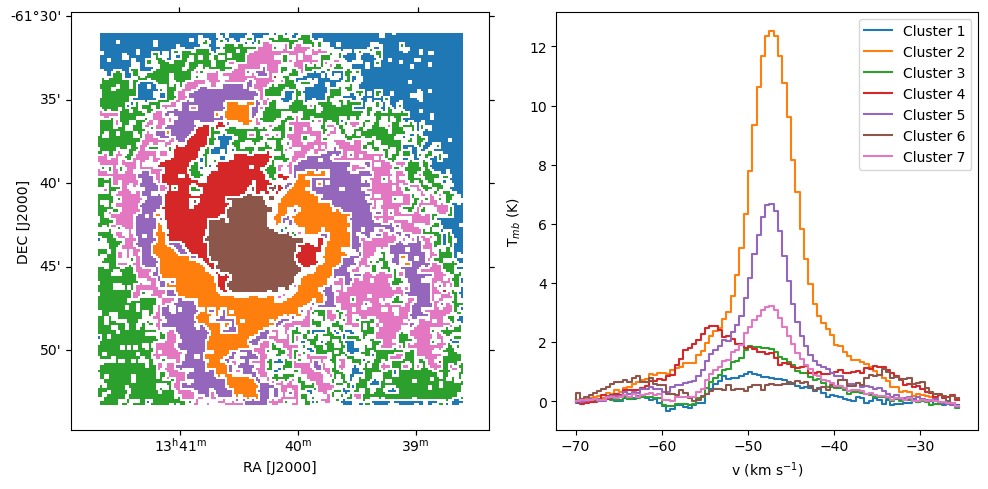

In [21]:
## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
## including pixels that do not have a confidently assigned cluster
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w, uncertain_map = uncertain_map, plot_path = 'plots/test_unc.pdf')